# Script used to analyze ice nucleation protein (INP) sequences
This was used to generate and analyze a dataset for our publication in eLife (2023):

[Ice nucleation proteins self-assemble into large fibres to trigger freezing at near 0 ℃ (reviewed preprint link)](https://elifesciences.org/reviewed-preprints/91976/reviews)

I never intended to share this publicly, but it was requested before publication of the work. This is not the most elegant code, but it works for what I made it to do. Please use/adapt freely, but do so at your own risk!

Authored by me (Thomas Hansen).

In [ ]:
#@title 0. Dependencies and set-up

# Biopython from PyPi, used for BLAST and Entrez API
!pip install Biopython
from Bio import Entrez
# Include e-mail in case NCBI thinks you're being bad, per https://www.ncbi.nlm.nih.gov/books/NBK25497/#chapter2.chapter2_table1
# "The value of email will be used only to contact developers if NCBI observes requests that violate our policies, and we will attempt such contact prior to blocking access."
# API key raises queries from 3 to 10 per second
Entrez.email = 'youremail@server.com' #@param {type:"string"}
Entrez.api_key = '36-digit hexadecimal key' #@param {type:"string"}

from IPython.display import clear_output
from tqdm import tqdm

#@markdown ⚠NOTE⚠: This script mounts your GoogleDrive and saves files to it!
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 31.8 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
#@title 1. BLAST
"""
setup/input/read
"""
import glob
from Bio.Blast import NCBIWWW
from lxml import etree
from datetime import datetime

#@markdown Upload previous BLAST .xml file (new_BLAST = False) or do a new BLAST (new_BLAST = True). If False, will use the first .xml file found!
new_BLAST = True #@param ["False", "True"] {type:"raw"}
#@markdown If True:

#@markdown query sequence:
input = 'AGYGSTQTAGEDSSLT' #@param {type:"string"}
if input is None:
  raise ValueError()
input_type = 'protein' #@param ["protein", "nucleotide", ".fasta"]

if input_type == '.fasta':
  with open(f'{input}.fasta') as input_handle:
    try:
      input_string = input_handle.read()
      # TO DO: assign nucleotide or protein based on the FASTA?
    except:
      raise()
      # handle error for not being able to read the FASTA
else:
  input_string = input

blast_program = 'blastp' #@param ["blastn", "blastp", "blastx", "tblastn"]
save_as = '' #@param {type:"string"}
if save_as == '':
  save_as = f'{datetime.now().strftime("%y%m%d")}-blast'

matrix_type = 'PAM30' #@param ["BLOSUM90", "BLOSUM80", "BLOSUM62", "BLOSUM50", "BLOSUM45", "PAM250", "PAM70", "PAM30"]
num_results = 5000 #@param {type:"slider", min:1, max:5000, step:1}
# PAM30 is a shallower matrix for better identity https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3848038/

db_dict = {'blastn':'nt',
           'blastp':'nr',
           'blastx':'nr',
           'tblastn':'nt'}

if new_BLAST == True:
  print(datetime.now(), 'Starting BLAST')
  blast_handle = NCBIWWW.qblast(program=blast_program, \
                                database=db_dict[blast_program], \
                                sequence=input_string, \
                                short_query=True, \
                                matrix_name=matrix_type, \
                                gapcosts='9 1', \
                                descriptions=num_results, \
                                alignments=num_results, \
                                hitlist_size=num_results)
  print(datetime.now(), 'Finished BLAST')
  # Write the result to disk. Also, the .read() method from qblast can only be done once!
  with open(f'{save_as}.xml', 'w') as out_handle:
    out_handle.write(blast_handle.read())
    print(datetime.now(), f'BLAST results saved as {save_as}.xml')
  blast_handle.close()

try:
  filename = glob.glob('*.xml')[0]
  print(datetime.now(), f'Using {filename} as BLAST results')
except:
  print(datetime.now(), 'No .xml file detected!')

2023-02-16 17:17:33.022052 Starting BLAST
2023-02-16 17:20:19.233379 Finished BLAST
2023-02-16 17:20:19.490539 BLAST results saved as 230216-blast.xml
2023-02-16 17:20:19.505360 Using 230216-blast.xml as BLAST results


In [ ]:
#@title 2. Get all accession numbers for BLAST hits (filtered by number of identities to input)

#@markdown Exact positional identities required for inclusion (0 to keep all results):
identity_threshold = 10 #@param {type:"integer"}
"""
Parsing BLAST results
"""

import re
import glob
import pandas as pd
from datetime import datetime

# get all accession id's from the BLAST, grouped by Hit number
# each hit can contain many accession numbers if they are identical!
# often they are unique sequencing projects that gave identical results
# it is valuable to know how many times a given sequence has been found

def ids_after_pipes(hit_text):
  # regex: lookbehind to |, then include alphanumeric up to the first dot, then the dot plus a single trailing character
  return re.findall('(?<=\|)[\w]+[\.\w]*',hit_text)

def blast_table_data(filename):
  with open(filename) as blast_handle:
    xml = blast_handle.read()
  root = etree.fromstring(xml)

  blast_results = []
  for hit in root.findall('.//Hit'):
    hit_num = hit.findtext('.//Hit_num')
    identities = int(hit.findtext('.//Hsp_identity'))
    # uses only the first (top scoring) HSP's identities for now
    if identities >= identity_threshold:
      hit_accessions = hit.findtext('Hit_def' if db_dict[blast_program] == 'nr' else 'Hit_id')
      e_value = hit.findtext('.//Hsp_evalue')
      for accession in ids_after_pipes(hit_accessions):
        blast_results.append((hit_num, accession, e_value, identities))
  return blast_results

try:
  filename = glob.glob('*.xml')[0]
except:
  print(datetime.now(), 'No .xml file detected!')

df_blast = pd.DataFrame(blast_table_data(filename),
                          columns=['Hit_num','Accession','E-value','Identities'])

# blast_table.to_parquet(f'{datetime.today().strftime("%y%m%d")}-blast_table.parquet')
print(datetime.now(), len(df_blast.index),'sequences that match at >=',identity_threshold,'positions')

2023-02-16 17:20:49.651134 1042 sequences that match at >= 10 positions


In [ ]:
# TO DO: Can I use a wrapper or decorator to combine all these Entrez utils?
#@title 3a. Define NCBI data scraping functions

import requests
from Bio import Entrez

def efetch_accession(id, db, rettype="gb"):
  # Check if a record has already been fetched. If not, fetch! Then return xml tree
  # TO DO: Add some option to disable downloads and use only local files
  id = id.split('.')[0]
  filename = f"/content/drive/MyDrive/efetch/{db}/{id}.xml"
  try:
    with open(filename) as entrez_handle:
      # print(datetime.now(), f"efetch_accession: {id}.xml locally")
      tree = etree.parse(entrez_handle)
  except:
    print(datetime.now(), f"efetch_accession: {id}.xml from NCBI")
    entrez_handle = Entrez.efetch(id=id, db=db, rettype=rettype, retmode = "xml")
    tree = etree.parse(entrez_handle)
    entrez_handle.close()
    tree.write(filename)
  return tree

def elink_by_linkname(id, linkname):
  id = id.split('.')[0]
  dbfrom = linkname.split("_")[0]
  db = linkname.split("_")[1]
  filename = f"/content/drive/MyDrive/elink/{linkname}/{id}_elink.xml"
  try:
    with open(filename) as entrez_handle:
      # print(datetime.now(), f"Elink from id: {filename} locally")
      tree = etree.parse(entrez_handle)
  except:
    # print(datetime.now(), f"Elink from id: {filename} from NCBI")
    entrez_handle = Entrez.elink(id=id, dbfrom=dbfrom, db=db, linkname=linkname, retmode="xml")
    tree = etree.parse(entrez_handle)
    entrez_handle.close()
    tree.write(filename)
  return tree

def esummary_from_id(id, db):
  id = id.split('.')[0]
  filename = f"/content/drive/MyDrive/esummary/{db}/{id}_esummary.xml"
  try:
    with open(filename) as entrez_handle:
      # print(datetime.now(), f"Esummary from id: {filename} locally")
      tree = etree.parse(entrez_handle)
  except:
    # print(datetime.now(), f"Esummary from id: Downloading {filename} from NCBI")
    entrez_handle = Entrez.esummary(id = id, db = db, version="2.0", retmode="xml")
    tree = etree.parse(entrez_handle)
    entrez_handle.close()
    tree.write(filename)
  return tree

def get_assembly_rpt(url, id):
  id = id.split('.')[0]
  filename = f"/content/drive/MyDrive/assembly_rpt/{id}_rpt.txt"
  try:
    with open(filename) as report_handle:
      # print(datetime.now(), f"Get_assembly_rpt: {filename} locally")
      assembly_rpt = report_handle.read()
  except:
    try:
      assembly_rpt_get = requests.get(url)
      try:
        with open(filename, "w") as out_handle:
          out_handle.write(assembly_rpt_get.text)
        assembly_rpt = assembly_rpt_get.text
        # print(datetime.now(), f"Get_aseembly_rpt: downloading {filename} from NCBI")
      except:
        print(datetime.now(), f"get_assembly_rpt: Couldn't write {filename}")
        return None
    except:
      print(datetime.now(), f"get_assembly_rpt: Couldn't get {id} from {url}")
      return None
  return assembly_rpt

def text_from_assembly_rpt(report, *tags):
  # Gets data from plaintext assembly reports on NCBI
  report_text = {}
  for tag in tags:
    for line in report.splitlines():
      if tag in line:
        report_text[tag] = (line.replace(f"# {tag}:","").lstrip(' '))
        break
    # If all lines are scanned without finding the tag, give an empty value. Probably faster than a while loop?
    if tag not in report_text.keys():
      # print(datetime.now(), f"No {tag} for {assembly_rpt.splitlines()[0]}")
      report_text[tag] = ""
  return report_text

In [ ]:
#@title 3b. Get protein data for each accession from BLAST
protein_data = {}
genbank_tags = ['GBSeq_accession-version','GBSeq_length','GBSeq_update-date','GBSeq_create-date','GBSeq_definition','GBSeq_project','GBSeq_organism','GBSeq_sequence']

for acc in tqdm(df_blast['Accession'], desc='Protein data from Efetch'):
  tree = efetch_accession(acc,"protein")

  acc_data = []
  for tag in genbank_tags:
    acc_data.append(tree.findtext('.//' + tag))
  protein_data[acc] = acc_data

df_proteins = pd.DataFrame.from_dict(protein_data, orient='index', columns=genbank_tags)
df_proteins = df_proteins.rename(columns={'GBSeq_accession-version' : 'Accession'})
# df_proteins.to_parquet(f'{datetime.now().strftime("%y%m%d")}-proteins.parquet')

Protein data from Efetch: 100%|██████████| 1042/1042 [03:42<00:00,  4.68it/s]


In [ ]:
#@title 4a. Define tandem array parsing functions
#@title New coil counter

#@markdown (leave blank to use BLAST input)
repeat = '' #@param {type: "string"}
if repeat == '':
  repeat = input_string
repeat = repeat.upper()

# brute force-ish for finding region of CONTINUOUS, UNGAPPED tandem repeats
def pairwise_identities(sequence, repeat):
  sequence = sequence.upper()
  matches = 0
  for j, k in zip(repeat, sequence):
    if j == k:
      matches += 1
  return matches

def find_repeats_start(sequence, repeat, threshold, start = 0):
  sequence = sequence[start:].upper()
  if start > 0:
    print(sequence)
  first_repeat = None
  for i in range(len(sequence)):
    matches = pairwise_identities(sequence[i:i+len(repeat)], repeat)
    # requiring the Y in the first repeat for INPs is a little hack-y but it works
    if matches >= threshold and sequence[i+2] == 'Y':
      first_repeat = i
      # false positives: check to see if it's matching a partial repeat
      if pairwise_identities(sequence[i+8:i+len(repeat)], repeat) > matches:
        first_repeat = i+8
        print('Frame shift +8 for', sequence)
      break
  return first_repeat

def find_repeats_end(sequence, repeat, threshold, start):
  sequence = sequence.upper()
  for i in range(start, len(sequence), len(repeat)):
    matches = pairwise_identities(sequence[i:i+len(repeat)], repeat)
    if matches >= threshold:
      continue
    else:
      return i
  return 0

def find_r_coil_start(repeat_list):
  consecutive_r = 0
  r_start = 0
  for i, repeat in enumerate(repeat_list):
    if repeat[11] in {'R','K'}:
      if r_start == 0:
        r_start = i
      if repeat[11] == 'R':
        consecutive_r += 2
      elif repeat[11] == 'K':
        consecutive_r += 1
    else:
      consecutive_r = max(0, consecutive_r-1)
      if consecutive_r == 0:
        r_start = 0
    if consecutive_r >= 4:
      # prevent false positives: check if Y-ladder is gone. if not, reset, keep looking
      if repeat[2] != 'Y':
        return r_start
      else:
        consecutive_r = 0
  return len(repeat_list)

def split_tandem_array(repeat_sequence, size):
  tandem_array = []
  # print(sequence,"length",len(sequence),"\n size:",size,"mod:",len(sequence)%size)
  for i in range(0, len(repeat_sequence), size):
    tandem_array.append(repeat_sequence[i:i+size].upper())
  return tandem_array

In [ ]:
#@title 4b. Parse tandem arrays
# TO DO: could switch from index-based to sequence-based indexing since duplicate sequences exist from BLAST
def parse_tandem_arrays(seq_series):
  partitioned_sequences = {}
  for index, sequence in seq_series.items():
    first_repeat = find_repeats_start(sequence, repeat, 8)
    if first_repeat is None:
      partitioned_sequences[index] = [sequence,'','','']
      continue
    final_repeat = find_repeats_end(sequence, repeat, 5, first_repeat)
    repeats = split_tandem_array(sequence[first_repeat:final_repeat], len(repeat))
    # to do: checking for false positives
    # probably means mapping out a number of residues that match the motif
    # getting the longest chain on the map separated by the repeat length
    r_coil_start = find_r_coil_start(repeats)
    # if r-coils aren't found, it's usually a "frameshift" by 8 residues. Could account for it.
    # if r_coil_start == len(repeats):
    #   if find_repeats_end(sequence, repeat, 5, first_repeat+8) > final_repeat:
    #     print("frameshift for",index,",previous final_repeat:",final_repeat,"new:",find_repeats_end(sequence, repeat, 5, first_repeat+8))
    #     repeats = split_tandem_array(sequence[first_repeat+8:final_repeat+8], len(repeat))
    #     print("r_coil_start before:",r_coil_start)
    #     r_coil_start = find_r_coil_start(repeats)
    #     print("r_coil_start after:",r_coil_start)
    partitioned_sequences[index] = [sequence[:first_repeat],
                                    repeats[:r_coil_start],
                                    repeats[r_coil_start:],
                                    sequence[final_repeat:],
                                    ]
  # if cterm is way too long or too short, try a different threshold?
  return pd.DataFrame.from_dict(partitioned_sequences, orient='index', columns=["nterm","wo_coils","r_coils","cterm"])

df_partitioned_sequences = parse_tandem_arrays(df_proteins['GBSeq_sequence'])
df_partitioned_sequences.index.rename('Accession', inplace=True)

df_blast_all_proteins = df_blast.merge(df_proteins, how='outer', on='Accession')
df_blast_all_proteins = df_blast_all_proteins.merge(df_partitioned_sequences, how='outer', on='Accession')
df_blast_all_proteins.to_csv(f'{datetime.today().strftime("%y%m%d")}-blast_and_all_proteins.csv')

In [ ]:
#@title 4c. Merge partitioned sequence to protein data, and prune results
minimum_repeat_number = 5 #@param {type:"integer"}

df_proteins_partitioned = df_proteins.merge(df_partitioned_sequences, left_index=True, right_index=True)

# various selection criteria to ensure complete sequence: Must start with Met, must have a C-terminal sequence, must have a minimum number of coils
df_proteins_pruned = df_proteins_partitioned[(df_proteins_partitioned['wo_coils'].map(len) >= 5) & \
                                             (df_proteins_partitioned['cterm'].map(len) >= 10) & \
                                             (df_proteins_partitioned['cterm'].map(len) <= 100) & \
                                             (df_proteins_partitioned['r_coils'].map(len) >= 1) & \
                                             (df_proteins_partitioned['nterm'].str[:1] == 'm')]

df_proteins_removed = df_proteins_partitioned[~df_proteins_partitioned.index.isin(df_proteins_pruned.index)]
print('Kept',len(df_proteins_pruned.index),'proteins')
print('Removed',len(df_proteins_removed.index),'proteins')

# df_proteins_partitioned.to_parquet(f'{datetime.today().strftime("%y%m%d")}-proteins_partitioned.parquet')
# df_proteins_pruned.to_parquet(f'{datetime.today().strftime("%y%m%d")}-proteins_pruned.parquet')
df_proteins_pruned.to_csv(f'{datetime.today().strftime("%y%m%d")}-proteins_over5.csv')
df_proteins_removed.to_csv(f'{datetime.today().strftime("%y%m%d")}-proteins_under5.csv')

Kept 608 proteins
Removed 434 proteins


In [ ]:
#@title 5a. Get BioProject UID for each BioProject accession
def get_bioproject_uids(accessions):
  bioproject_uid = {}
  for accession in tqdm(accessions, desc='BioProject UID from Accession'):
    if accession == None:
      continue
    if accession in bioproject_uid:
      continue
    entrez_handle = Entrez.esearch(term=accession, db="bioproject", rettype="uilist", retmode="xml")
    tree = etree.parse(entrez_handle)
    bioproject_uid[accession] = tree.findtext('.//Id')
  df_uids = pd.DataFrame.from_dict(bioproject_uid, orient='index', columns=['Project_Id'], dtype=str)
  df_uids.index.rename('GBSeq_project', inplace=True)
  df_uids = df_uids.replace({float('nan'): None})
  return df_uids

df_bioproject_uid = get_bioproject_uids(df_proteins_pruned['GBSeq_project'])
# df_bioproject_uid.to_parquet(f'{datetime.today().strftime("%y%m%d")}-bioproject_uid.parquet')

BioProject UID from Accession: 100%|██████████| 608/608 [01:08<00:00,  8.93it/s]


In [ ]:
#@title 5b. BioProject data for each BioProject UID
def get_bioproject_data(uid_list):
  bioprojects_data = {}
  bioproject_tags = ['Project_Id','Project_Target_Scope','Project_Data_Type','Sequencing_Status','Project_Title','Project_Description']

  for uid in tqdm(uid_list, desc='BioProject data from Esummary'):
    if uid == None:
      # print(f"Protein {protein_data['Accession']} has no BioProject")
      continue
    if uid in bioprojects_data:
      continue

    tree = esummary_from_id(uid, "bioproject")

    uid_data = []
    for tag in bioproject_tags:
      uid_data.append(tree.findtext('.//' + tag))
    bioprojects_data[uid] = uid_data
    df = pd.DataFrame.from_dict(bioprojects_data, orient='index', columns=bioproject_tags)
  return df
    # print(tree_data)
df_bioproject_data = get_bioproject_data(df_bioproject_uid['Project_Id'])
# df_bioproject_data.to_parquet(f'{datetime.today().strftime("%y%m%d")}-bioproject_data.parquet')

BioProject data from Esummary: 100%|██████████| 300/300 [00:00<00:00, 307.62it/s]


In [ ]:
#@title 5c. Merge BioProject UID, BioProject data, protein data, and BLAST
df_proteins_and_bioprojects = df_blast.merge(df_proteins_pruned, how='right', on='Accession')
df_proteins_and_bioprojects = df_proteins_and_bioprojects.merge(df_bioproject_uid, how='outer', on='GBSeq_project')
df_proteins_and_bioprojects = df_proteins_and_bioprojects.merge(df_bioproject_data, how='outer', on='Project_Id')
# df_proteins_and_bioprojects.to_parquet(f'{datetime.today().strftime("%y%m%d")}-proteins_and_bioprojects.parquet')
df_proteins_and_bioprojects.to_csv(f'{datetime.today().strftime("%y%m%d")}-proteins_and_bioprojects.csv')

In [ ]:
#@title 6a. Find assembly data for all assemblies associated with a BioProject
#@markdown Some BioProjects have >10,000 associated assemblies
#@markdown (e.g. https://www.ncbi.nlm.nih.gov/bioproject/?term=657437), the
#@markdown result of a huge amount of shotgun sequencing or similarly large
#@markdown scale effort. This tells the script to look at only the first _x_.
#@markdown (The final report will still tell you the total number of assemblies)

max_assemblies_per_bioproject = 25 #@param {type:"slider", min:1, max:1000, step:1}

def get_assembly_data(bioproject_ids):
  # would it be worth getting N50 and L50 in here?
  assembly_tags = ["Genome coverage", "Sequencing technology", "Expected final version"]
  assembly_data = {}

  for project_id in bioproject_ids:
    assembly_ids = []
    genome_coverage = []
    sequencing_tech = []
    expected_final = []
    report_urls = []

    # skip empty BioProjects
    if project_id == None:
      continue
    if project_id in assembly_data:
      continue
    tree = elink_by_linkname(project_id, "bioproject_assembly")
    try:
      project_assemblies = tree.findall('.//Link/Id')
    except:
      print(datetime.now(), f"BioProject {project_id} didn't link to any Assemblies")
      assembly_data[project_id] = None
      continue
    # print(datetime.now(), f"Linked {len(project_assemblies)} assemblies to BioProject {bioproject_id}")

    # for each assembly, read the assembly report
    # TO DO: Use epost for the assembly_ids?
    for assembly_link in tqdm(project_assemblies[:max_assemblies_per_bioproject], desc=f"Assembly data for BioProject {project_id}"):
      assembly_id = assembly_link.text
      tree = esummary_from_id(assembly_id,db="assembly")
      try:
        assembly_rpt_ftp = tree.findtext('.//FtpPath_Stats_rpt')
      except:
        print(datetime.now(), f"No <FtpPath_Stats_rpt> tag in esummary for {assembly_id}")
        assembly_ids.append(assembly_id)
        genome_coverage.append(None)
        sequencing_tech.append(None)
        expected_final.append(None)
        report_urls.append(None)
        continue
      URL = assembly_rpt_ftp.replace("ftp://","https://")
      assembly_rpt = get_assembly_rpt(URL, assembly_id)
      # from the report, extract information
      assembly_data_list = text_from_assembly_rpt(assembly_rpt, *assembly_tags)

      # TO DO: just call the function for each tag in a for loop? something like:
      # for tag in assembly_tags:
      #   tag.append(text_from_assembly_rpt(assembly_rpt, tag))
      # then separate the data
      assembly_ids.append(assembly_id)
      genome_coverage.append(assembly_data_list["Genome coverage"])
      sequencing_tech.append(assembly_data_list["Sequencing technology"])
      expected_final.append(assembly_data_list["Expected final version"])
      report_urls.append(URL)
      # print(datetime.now(), f"BioProject {bioproject_id}: Extracted Assembly data for {assembly_id}")

    # https://www.ncbi.nlm.nih.gov/bioproject/?term=724448 has no sequencing technology
    # but it does have links to SRA experiments which do! Illumina and MinION
    # Use this as a failsafe for if Assembly archive doesn't have it
    if all(s == None for s in assembly_data_list["Sequencing technology"]):
      tree = elink_by_linkname(project_id, "bioproject_sra")
      links = []
      for l in tree.findall('.//Link/Id'):
        links.append(l.text)
      sequencing_tech = []
      for l in links[:max_assemblies_per_bioproject]:
        tree = esummary_from_id(l, "sra")
        ExpXml = tree.findtext('.//ExpXml')
        # regex: Anything between a > and </Platform> (spaces included)
        sequencing_tech.append(re.findall("[^\>]+(?=<\/Platform>)", ExpXml))

    assembly_data[project_id] = [len(project_assemblies), assembly_ids, genome_coverage, sequencing_tech, expected_final, report_urls]
    # clear_output()
  # assembly_data_df = pd.DataFrame(assembly_data, columns=assembly_tags)
  assembly_data_df = pd.DataFrame.from_dict(assembly_data, orient='index', columns=['assembly_count','assembly_ids','genome_coverage','sequencing_tech','expected_final_version','report_urls'])
  assembly_data_df.index.rename('Project_Id', inplace=True)
  return assembly_data_df

df_assembly_data = get_assembly_data(df_bioproject_uid['Project_Id'].unique())
# df_assembly_data.to_parquet(f'{datetime.today().strftime("%y%m%d")}-assembly_data.parquet')
# df_assembly_data.to_csv(f'{datetime.today().strftime("%y%m%d")}-assembly_data.csv')

Assembly data for BioProject 304675: 100%|██████████| 8/8 [00:00<00:00, 206.17it/s]


In [ ]:
#@title 6b. Merge assembly data with protein and BioProject data
df_complete = df_proteins_and_bioprojects.merge(df_assembly_data, how='outer', on='Project_Id')
df_complete.to_csv(f'{datetime.today().strftime("%y%m%d")}-complete_blast.csv')

In [ ]:
#@title 6c. Limit sequences to long-read technology only
df_complete = df_complete.astype({'sequencing_tech':str})
df_longread = df_complete[df_complete['sequencing_tech'].str.contains(r"Oxford|PacBio|ONT|Pacific", na=False)]
df_longread.to_csv(f'{datetime.today().strftime("%y%m%d")}-complete_blast_longread.csv')

df_unique = df_longread.drop_duplicates(subset=['Hit_num'])
print("Number of unique sequences:", len(df_unique))

In [ ]:
 #@title 7a. List all WO-coils and R-coils
df_unique = df_longread.drop_duplicates(subset=['Hit_num'])
wo_coils = []
for coils in df_unique['wo_coils']:
  for coil in coils:
    wo_coils.append(coil)
with open(f'{datetime.today().strftime("%y%m%d")}-wo_coils.txt', 'w') as out_handle:
  out_handle.write('\n'.join(wo_coils))

r_coils = []
for coils in df_unique['r_coils']:
  for coil in coils:
    r_coils.append(coil)
with open(f'{datetime.today().strftime("%y%m%d")}-r_coils.txt', 'w') as out_handle:
  out_handle.write('\n'.join(r_coils))

In [ ]:
!pip install logomaker
# citation info: https://logomaker.readthedocs.io/en/latest/index.html

# 7a. Make logos

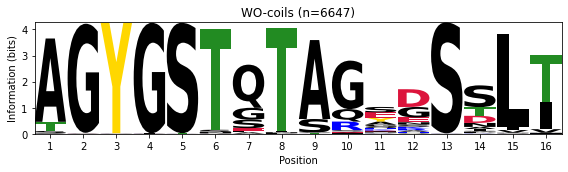

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logomaker as lm

%matplotlib inline

counts_mat = lm.alignment_to_matrix(wo_coils)
info_mat = lm.transform_matrix(counts_mat,
                                      from_type='counts',
                                      to_type='information')

fig, ax = plt.subplots(figsize=(8, 2.5))
wo_logo = lm.Logo(info_mat,
                  color_scheme='chemistry',
                  ax=ax)
wo_logo.style_glyphs({'A':'black',
                      'C':'black',
                      'D':'crimson',
                      'E':'crimson',
                      'F':'black',
                      'G':'black',
                      'H':'blue',
                      'I':'black',
                      'K':'blue',
                      'L':'black',
                      'M':'black',
                      'N':'black',
                      'P':'black',
                      'Q':'black',
                      'R':'blue',
                      'S':'black',
                      'T':'forestgreen',
                      'V':'black',
                      'W':'black',
                      'Y':'gold'})
ax.set_title(f'WO-coils (n={len(wo_coils)})')
ax.set_ylabel("Information (bits)")
ax.set_xlabel("Position")
wo_logo.style_xticks(rotation=0, anchor=1)
ax.set_xticklabels(range(1,17))
fig.tight_layout()
fig.savefig(f'{datetime.today().strftime("%y%m%d")}-wo_coil_logo.svg')
fig.savefig(f'{datetime.today().strftime("%y%m%d")}-wo_coil_logo.png', dpi=300)

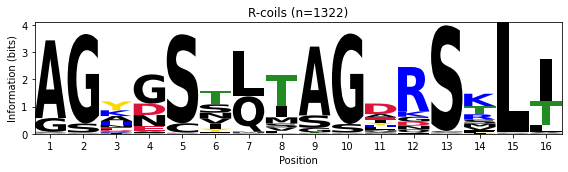

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logomaker as lm

%matplotlib inline

counts_mat = lm.alignment_to_matrix(r_coils)
info_mat = lm.transform_matrix(counts_mat,
                                      from_type='counts',
                                      to_type='information')

fig1, ax1 = plt.subplots(figsize=(8, 2.5))
r_logo = lm.Logo(info_mat,
                  color_scheme='chemistry',
                  ax=ax1)
r_logo.style_glyphs({'A':'black',
                      'C':'black',
                      'D':'crimson',
                      'E':'crimson',
                      'F':'black',
                      'G':'black',
                      'H':'blue',
                      'I':'black',
                      'K':'blue',
                      'L':'black',
                      'M':'black',
                      'N':'black',
                      'P':'black',
                      'Q':'black',
                      'R':'blue',
                      'S':'black',
                      'T':'forestgreen',
                      'V':'black',
                      'W':'black',
                      'Y':'gold'})
ax1.set_title(f'R-coils (n={len(r_coils)})')
ax1.set_ylabel("Information (bits)")
ax1.set_xlabel("Position")
r_logo.style_xticks(rotation=0, anchor=1)
ax1.set_xticklabels(range(1,17))
fig1.tight_layout()
fig1.savefig(f'{datetime.today().strftime("%y%m%d")}-r_coil_logo.svg')
fig1.savefig(f'{datetime.today().strftime("%y%m%d")}-r_coil_logo.png', dpi=300)

In [ ]:
#@title 7b. For each sequence, count the number of WO- and R-coils
plot_df = pd.DataFrame()
plot_df['accession'] = df_unique['Accession']
plot_df['wo_coils'] = df_unique['wo_coils'].map(len)
plot_df['r_coils'] = df_unique['r_coils'].map(len)
plot_df.index = range(len(plot_df.index))
plot_df = plot_df.sort_values(['wo_coils','r_coils'], ascending=False)

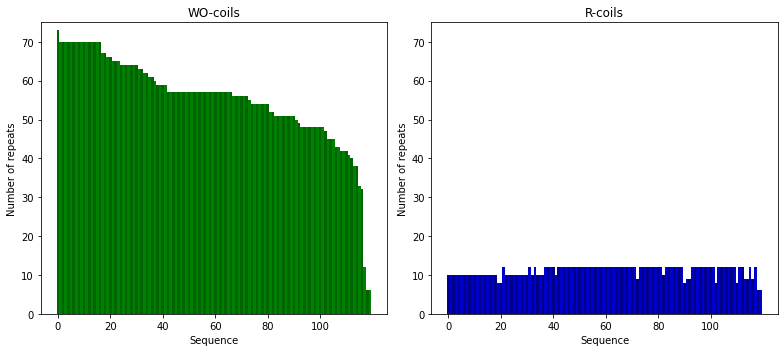

In [ ]:
#@title 7b. Plot number of WO-coils vs R-coils
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(11, 5)

ax1.bar(x=plot_df['accession'],
        height=plot_df['wo_coils'],
        width=1,
        color=['darkgreen','green'])
ax1.set_title('WO-coils')
ax1.set_ylabel('Number of repeats')
ax1.set_ylim(0,75)
ax1.set_xlabel('Sequence')
# ax1.set_xticks(range(0,len(plot_df['wo_coils']),10),
#                range(1,len(plot_df['wo_coils']+1),10))
#ax1.set_xticks(ax.get_xticks()[::10])
#ax1.set_xticklabels(range(1,len(plot_df['wo_coils']+1)))

ax2.bar(x=plot_df['accession'],
        height=plot_df['r_coils'],
        width=1,
        color=['darkblue','mediumblue'])
ax2.set_title('R-coils')
ax2.set_ylabel('Number of repeats')
ax2.set_ylim(0,75)
ax2.set_xlabel('Sequence')

tick_space = 20
ax1.set_xticks(ax1.get_xticks()[::tick_space])
ax1.set_xticklabels(range(0,len(plot_df['wo_coils']),tick_space))
ax2.set_xticks(ax2.get_xticks()[::tick_space])
ax2.set_xticklabels(range(0,len(plot_df['r_coils']),tick_space))

fig.tight_layout()
fig.savefig(f'{datetime.today().strftime("%y%m%d")}-coil-count-compare.svg')
fig.savefig(f'{datetime.today().strftime("%y%m%d")}-coil-count-compare.png', dpi=300)

In [ ]:
plot_df[plot_df['r_coils'] <= 9]

,accession,wo_coils,r_coils
90,QJI45388.1,66,8
108,QWM98342.1,66,8
60,UWF51541.1,56,9
94,QZB00219.1,51,8
68,UNM22147.1,50,9
77,UKE52099.1,49,9
95,QKG64268.1,47,8
96,QQO01011.1,42,8
34,MCF5793059.1,38,9
35,MCF5690667.1,38,9


# Scratch code

## Orchard samples

In [ ]:
import pandas as pd
df = pd.read_csv('230216-complete_blast_longread.csv', index_col=False)

from ast import literal_eval
df['wo_coils'] = df['wo_coils'].apply(lambda x: literal_eval(x))
df['r_coils'] = df['r_coils'].apply(lambda x: literal_eval(x))

In [ ]:
df_ps = df[(df['Project_Id'] == 587608) & (df['GBSeq_organism'].str.contains('syringae'))]

In [ ]:
df[df['Project_Id'] == 587608].shape

(34, 28)

In [ ]:
df[df['Project_Id'] == 587608].GBSeq_organism

32       Pseudomonas syringae
33       Pseudomonas syringae
34       Pseudomonas syringae
35       Pseudomonas syringae
36       Pseudomonas syringae
37       Pseudomonas syringae
38       Pseudomonas syringae
39       Pseudomonas syringae
40       Pseudomonas syringae
41       Pseudomonas syringae
42       Pseudomonas syringae
43       Pseudomonas syringae
44         Pseudomonas tremae
45         Pseudomonas tremae
46         Pseudomonas tremae
47         Pseudomonas tremae
48       Pseudomonas syringae
49       Pseudomonas syringae
50       Pseudomonas syringae
51    Pseudomonas sp. PA-1-6B
52    Pseudomonas sp. PA-1-8C
53    Pseudomonas sp. PA-1-2A
54         Pseudomonas carnis
55         Pseudomonas tremae
56       Pseudomonas syringae
57       Pseudomonas syringae
58       Pseudomonas syringae
59       Pseudomonas syringae
60       Pseudomonas syringae
61       Pseudomonas syringae
62       Pseudomonas syringae
63       Pseudomonas syringae
64       Pseudomonas syringae
65       P

In [ ]:
df_ps.wo_coils.map(len)

32    57
33    57
34    57
35    57
36    57
37    57
38    48
39    48
40    48
41    48
42    48
43    48
48    45
49    42
50    42
56    51
57    48
58    45
59    45
60    45
61    45
62    45
63    45
64    42
65    33
Name: wo_coils, dtype: int64

In [ ]:
df_ps.r_coils.map(len)

32    12
33    12
34    12
35    12
36    12
37    12
38    12
39    12
40    12
41    12
42    12
43    12
48    12
49    12
50    12
56    12
57    12
58    12
59    12
60    12
61    12
62    12
63    12
64    12
65    12
Name: r_coils, dtype: int64

Text(0.5, 0, 'Number of WO-coils')

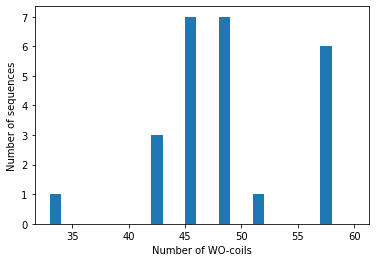

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.hist(df_ps.wo_coils.map(len), bins=27, range=(33,60))
ax.set_ylabel('Number of sequences')
ax.set_xlabel('Number of WO-coils')

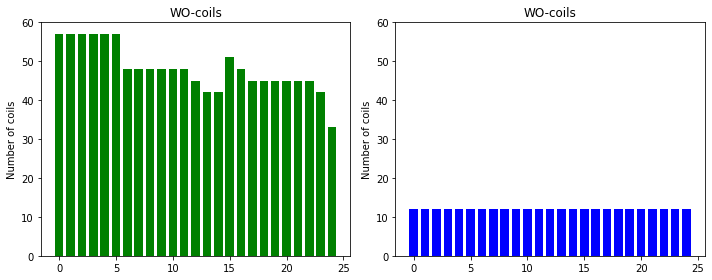

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10,4)
ax1.bar(x=range(len(df_ps)),
        width=0.75,
        color='green',
        height=df_ps.wo_coils.map(len))
ax2.bar(x=range(len(df_ps)),
        width=0.75,
        color='blue',
        height=df_ps.r_coils.map(len))
ax1.set_ylim(0,60)
ax2.set_ylim(0,60)
ax1.set_ylabel('Number of coils')
ax2.set_ylabel('Number of coils')
ax1.set_title('WO-coils')
ax2.set_title('WO-coils')
fig.tight_layout()

# Seq logo for Cterm

In [ ]:
!pip install logomaker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 38.8 MB/s eta 0:00:00


' is not in color_dict. Using black.
' is not in color_dict. Using black.


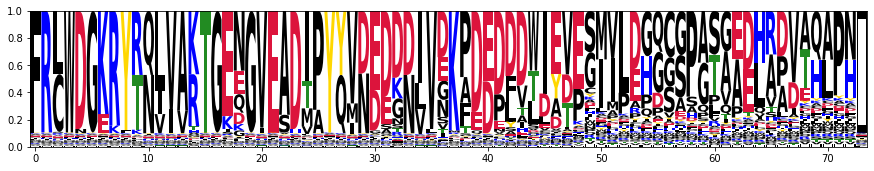

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logomaker as lm

%matplotlib inline

cterms_aligned = []
seq = ''
with open('230303-clustal_cterm_aligned.txt') as input_handle:
    for line in input_handle.readlines():
        cterms_aligned.append(line)

# ser = pd.Series(cterms_aligned)
counts_mat = lm.alignment_to_matrix(sequences=cterms_aligned, to_type='counts', characters_to_ignore='.-Xx')
prob_mat = lm.transform_matrix(counts_mat,
                                from_type='counts',
                                to_type='probability')
# info_mat = lm.transform_matrix(counts_mat,
#                                 from_type='counts',
#                                 to_type='information')

fig, ax = plt.subplots(figsize=(15, 2.5))
wo_logo = lm.Logo(prob_mat,
                  color_scheme='chemistry',
                  ax=ax)
wo_logo.style_glyphs({'A':'black',
                      'C':'black',
                      'D':'crimson',
                      'E':'crimson',
                      'F':'black',
                      'G':'black',
                      'H':'blue',
                      'I':'black',
                      'K':'blue',
                      'L':'black',
                      'M':'black',
                      'N':'black',
                      'P':'black',
                      'Q':'black',
                      'R':'blue',
                      'S':'black',
                      'T':'forestgreen',
                      'V':'black',
                      'W':'black',
                      'Y':'gold'})
# ax.set_title(f'WO-coils (n={len(wo_coils)})')
# ax.set_ylabel("Information (bits)")
# ax.set_xlabel("Position")
# wo_logo.style_xticks(rotation=0, anchor=1)
# ax.set_xticklabels(range(1,73))
# fig.tight_layout()
# fig.savefig(f'{datetime.today().strftime("%y%m%d")}-wo_coil_logo.svg')
# fig.savefig(f'{datetime.today().strftime("%y%m%d")}-wo_coil_logo.png', dpi=300)